## **Classifier Training**
- [ ] Train Random Forest on combined features  
- [ ] Tune hyperparameters (n_estimators, max_depth)

## **Classification Evaluation**
- [ ] Test classifier on validation set  
- [ ] Generate confusion matrix  

## Cell 1: Setup imports & paths

In [12]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Paths
DATA_DIR  = os.path.join(project_root, "Data")
MODEL_DIR = os.path.join(project_root, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

X_train = np.load(os.path.join(DATA_DIR, "X_train_combined.npy"))
X_val   = np.load(os.path.join(DATA_DIR, "X_val_combined.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "X_test_combined.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train_combined.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val_combined.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test_combined.npy"))

print("Training samples:", X_train.shape, y_train.shape)
print("Validation samples:", X_val.shape, y_val.shape)
print("Test samples:", X_test.shape, y_test.shape)

Training samples: (1050, 9124) (1050,)
Validation samples: (300, 9124) (300,)
Test samples: (150, 9124) (150,)


## Cell 2: Train baseline Random Forest

In [2]:
# Baseline RF
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Validate
y_val_pred = rf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

        cars       0.72      0.82      0.77        60
  motorcycle       0.71      0.83      0.77        60
 non-vehicle       0.90      0.90      0.90        60
  threewheel       0.78      0.70      0.74        60
      trucks       0.83      0.67      0.74        60

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300



## Cell 3: Hyperparameter Tuning (Grid Search)

In [3]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid, cv=3, scoring="accuracy", verbose=2, n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
best_rf = grid.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'max_depth': None, 'n_estimators': 200}


## Cell 4: Evaluate Tuned Model on Validation

In [6]:
y_val_pred = best_rf.predict(X_val)
print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Tuned Validation Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

        cars       0.75      0.78      0.76        60
  motorcycle       0.74      0.83      0.78        60
 non-vehicle       0.87      0.92      0.89        60
  threewheel       0.78      0.72      0.75        60
      trucks       0.78      0.67      0.72        60

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



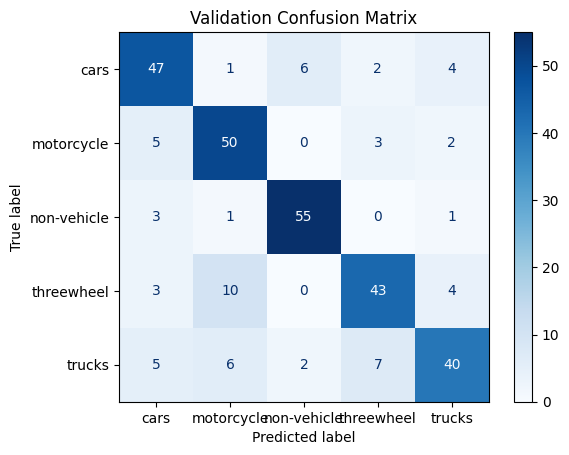

In [7]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf, X_val, y_val, cmap="Blues")
disp.ax_.set_title("Validation Confusion Matrix")
plt.show()

## Cell 5: Retrain on Train+Val and Final Test Evaluation

In [9]:
# Retrain on combined train+val
X_comb = np.vstack([X_train, X_val])
y_comb = np.concatenate([y_train, y_val])
final_rf = RandomForestClassifier(**grid.best_params_, random_state=42, n_jobs=-1)
final_rf.fit(X_comb, y_comb)

# Test set
y_test_pred = final_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.76
              precision    recall  f1-score   support

        cars       0.72      0.77      0.74        30
  motorcycle       0.66      0.90      0.76        30
 non-vehicle       0.89      0.80      0.84        30
  threewheel       0.81      0.73      0.77        30
      trucks       0.78      0.60      0.68        30

    accuracy                           0.76       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.77      0.76      0.76       150



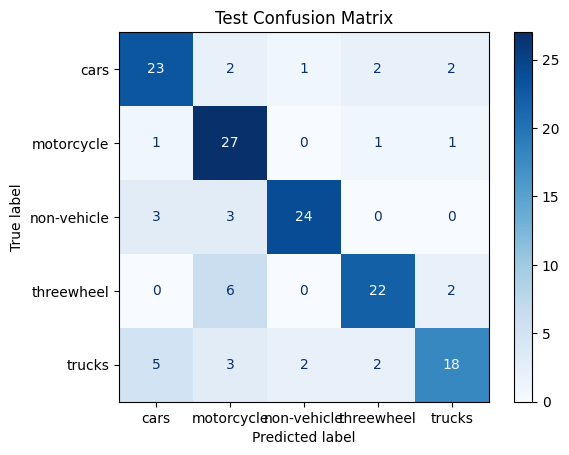

In [10]:
disp = ConfusionMatrixDisplay.from_estimator(final_rf, X_test, y_test, cmap="Blues")
disp.ax_.set_title("Test Confusion Matrix")
plt.show()

## Cell 6: Save the Final Model

In [13]:
import joblib
joblib.dump(final_rf, os.path.join(MODEL_DIR, "rf_combined_final.pkl"))
print("✅ Model saved to models/rf_combined_final.pkl")

✅ Model saved to models/rf_combined_final.pkl
